In [3]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

sim_name = f"Dopri5_1k"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)


### ------------------- ###
### Earth-Sun distances ###
### ------------------- ###

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('Data/Earth-Sun_distances.xlsx')

ES_distances = jnp.array(df.iloc[:, 1::2].apply(pd.to_numeric, errors='coerce')\
                                  .stack().reset_index(drop=True).tolist())[:-1]
ES_dists_kpc = ES_distances*Params.AU/Params.kpc

# print(ES_distances[jnp.array([0,-1])])
#? first and last day are the same day? since there are 366 elements?

days = jnp.arange(1,len(ES_distances)+1)
print(ES_distances.shape, days.shape)
print(ES_distances[0], ES_dists_kpc[0])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(365,) (365,)
0.9833098 4.7672204384173685e-09


# Solar gravity function

In [ ]:
@jax.jit
def sun_gravity(x_i, com_sun, eps):

    # x_i = x_i - com_sun
    r_i = jnp.linalg.norm(x_i)

    quot = x_i/jnp.power((r_i**2 + eps**2), 3./2.)
    gradient_sun = Params.G*Params.Msun*quot
    # gradient_sun = Params.G*Params.Msun*x_i/(r_i**3 + eps)

    # Acceleration is negative value of (grav. pot.) gradient.
    return -gradient_sun

com_sun = jnp.array([0.,0.,0.])

# init_coords = jnp.load(f"{sim_folder}/init_xyz_halo1.npy")*Params.kpc
# init_coords = jnp.load(f"{sim_folder}/init_xyz_modulation.npy")*Params.kpc
# print(init_coords/Params.kpc)
init_dis = ES_dists_kpc[0]*Params.kpc
print(init_dis)
init_coords = np.array([float(init_dis), 0., 0.])

init_vels = jnp.load(
    f"{sim_folder}/initial_velocities.npy")*(Params.kpc/Params.s)
print(init_vels[0,0,:])#*(Params.kpc/Params.s)/(Params.km/Params.s))

eps = 350_000/3e16*Params.kpc
# eps = 0.
grad_sun = sun_gravity(init_coords, com_sun, eps)
print(grad_sun)

# Replace NaNs with zeros and apply cutoff
grad_sun = jnp.nan_to_num(grad_sun)
cutoff = 1e-35
grad_sun = jnp.where(jnp.abs(grad_sun) < cutoff, 0.0, grad_sun)

grad_sun /= (Params.kpc/Params.s**2)
print(grad_sun)

# Compare sun and cell gravity

In [ ]:
z_int_steps = jnp.load(f'{sim_folder}/z_int_steps_1year.npy')
s_int_steps = jnp.load(f'{sim_folder}/s_int_steps_1year.npy')
z_test = 0.
idx = jnp.abs(z_int_steps - z_test).argmin()

# Load gravity 
halo_ID = 53
data_dir = f"Data/halo_grids"
dPsi_grids, cell_grids, cell_gens = SimGrid.grid_data(halo_ID, data_dir)
snaps_GRID_L = jnp.load(f'{data_dir}/snaps_GRID_L_halo1.npy')

dPsi_grid = dPsi_grids[idx]
cell_grid = cell_grids[idx]
cell_gens = cell_gens[idx]
snap_GRID_L = snaps_GRID_L[idx]

x_i = jnp.array([8.1, 0., 0.])*Params.kpc
cell_idx, *_ = SimExec.nu_in_which_cell(
    x_i, cell_grid, cell_gens, snap_GRID_L)
grad_tot = dPsi_grid[cell_idx, :]

# Test sun gravity

In [26]:
def sun_gravity(x_i, eps):

    r_i = jnp.linalg.norm(x_i)

    quot = x_i/jnp.power((r_i**2 + eps**2), 3./2.)
    gradient_sun = Params.G*Params.Msun*quot

    # Acceleration is negative value of (grav. pot.) gradient.
    return -gradient_sun

# Compute gradient of sun.
init_dis = ES_dists_kpc[0]  # without *kpc units
x_i = np.array([init_dis, 0., 0.])*Params.kpc
eps = (696_340/(3.086e16))*Params.kpc  #? solar radius or diameter
grad_sun = sun_gravity(x_i, eps)
ic(grad_sun)

# Switch to "physical reality" here.
# grad_sun /= (Params.kpc/Params.s**2)
grad_sun /= (Params.m/1e3/Params.s**2)  # should be around ~6 millimeter/s^2
ic(grad_sun)

ic| grad_sun: Array([-1.34651298e-26, -0.00000000e+00, -0.00000000e+00], dtype=float64)
ic| grad_sun: Array([-6.13289431, -0.        , -0.        ], dtype=float64)


Array([-6.13289431, -0.        , -0.        ], dtype=float64)

# Creation of integration steps (z and s)

In [ ]:
from astropy.time import Time
from scipy.integrate import quad

def z_at_age(age):
    
    # Function to calculate redshift for a given age of the universe
    def age_diff(z):
        return cosmo.age(z).to(apu.year).value - age
    
    # Use root_scalar to find the redshift that gives the specified age
    sol = root_scalar(
        age_diff, bracket=[0, 10], method='brentq', xtol=1e-12, rtol=1e-12)
    return sol.root

def get_redshift_array():

    # Today's date
    today = Time.now()
    
    # Calculate redshift for each day in the past year
    days = 365
    redshifts = jnp.zeros(days)
    age_today = cosmo.age(0).to(apu.year).value  # Age of the universe today
    for day in range(days):

        # Calculate the date for each day of the past year
        past_date = today - day*apu.day
        
        # Calculate the lookback time in years
        lookback_time = (today - past_date).to(apu.year).value
        
        # Calculate the age of the universe at this lookback time
        age_of_universe_then = age_today - lookback_time
        
        # Find the redshift corresponding to this age of the universe
        redshift = z_at_age(age_of_universe_then)
        
        # Store the redshift value in the array
        redshifts = redshifts.at[day].set(redshift)
    
    return redshifts


def s_of_z(z, args):
    """
    Convert redshift to time variable s with eqn. 4.1 in Mertsch et al.
    (2020), keeping only Omega_M and Omega_L in the Hubble eqn. for H(z).

    Args:
        z (float): redshift

    Returns:
        float: time variable s (in [seconds] if 1/H0 factor is included)
    """    

    def s_integrand(z):        

        # We need value of H0 in units of 1/s.
        H0_val = args.H0/(1/args.s)
        a_dot = np.sqrt(args.Omega_M*(1.+z)**3 + args.Omega_L)/(1.+z)*H0_val
        s_int = 1./a_dot

        return s_int

    s_of_z, _ = quad(s_integrand, 0., z)

    return jnp.float64(s_of_z)


# Get the redshift array for the past year
z_int_steps_1year = get_redshift_array()
# print(z_int_steps_1year)

# s_int_steps_1year = jnp.array([s_of_z(z, Params()) for z in z_int_steps_1year])
# print(s_int_steps_1year.min(), s_int_steps_1year[2], s_int_steps_1year.max())
# for i in range(5):
#     dt0 = (s_int_steps_1year[i+2]+s_int_steps_1year[i+1])/10_000
#     print(dt0)

jnp.save(f"{sim_folder}/z_int_steps_1year.npy", z_int_steps_1year)
jnp.save(f"{sim_folder}/s_int_steps_1year.npy", s_int_steps_1year)

In [ ]:
norm = s_int_steps_1year[-1]
s_normed = s_int_steps_1year/norm
print(s_normed[:10])
print(s_normed[-10:])

In [ ]:
np.diff(s_int_steps)

# Mini-Sim: 1 Pixel

### Run simulation

In [127]:
@jax.jit
def EOMs_sun(s_val, y, args):

    # Unpack the input data
    s_int_steps, z_int_steps, kpc, s = args

    # Initialize vector.
    x_i, u_i = y

    # Switch to "numerical reality" here.
    x_i *= kpc
    u_i *= (kpc/s)

    # Find z corresponding to s via interpolation.
    z = Utils.jax_interpolate(s_val, s_int_steps, z_int_steps)

    # Compute gradient of sun.
    eps = (696_340/(3.086e16))*kpc
    grad_sun = SimExec.sun_gravity(x_i, eps)

    # Switch to "physical reality" here.
    grad_sun /= (kpc/s**2)
    x_i /= kpc
    u_i /= (kpc/s)

    # Hamilton eqns. for integration (global minus, s.t. we go back in time).
    # dyds = -jnp.array([
    #     u_i, 1./(1.+z)**2 * grad_sun
    # ])

    # Relativistic EOMs for integration (global minus, s.t. we go back in time).
    dyds = -jnp.array([
        u_i/(1+z)**2 / jnp.sqrt(jnp.sum(u_i**2) + (1+z)**-2), 
        1/(1+z)**2 * grad_sun
    ])

    return dyds


@jax.jit
def EOMs_no_gravity(s_val, y, args):

    # Initialize vector.
    _, u_i = y

    # Hamilton eqns. for integration (global minus, s.t. we go back in time).
    dyds = -jnp.array([
        u_i, jnp.zeros(3)
    ])

    return dyds


@jax.jit
def backtrack_1_neutrino(init_vector, s_int_steps, z_int_steps, kpc, s):

    """
    Simulate trajectory of 1 neutrino. Input is 6-dim. vector containing starting positions and velocities of neutrino. Solves ODEs given by the EOMs function with an jax-accelerated integration routine, using the diffrax library. Output are the positions and velocities at each timestep, which was specified with diffrax.SaveAt. 
    """

    # Initial vector in correct shape for EOMs function
    y0 = init_vector.reshape(2,3)

    # ODE solver setup
    term = diffrax.ODETerm(EOMs_sun)
    t0 = s_int_steps[0]
    t1 = s_int_steps[-1]
    dt0 = (s_int_steps[-1] - s_int_steps[0]) / 30

    ### ------------------ ###
    ### Integration Solver ###
    ### ------------------ ###

    solver = diffrax.Dopri5()
    stepsize_controller = diffrax.ConstantStepSize()

    # Specify timesteps where solutions should be saved
    saveat = diffrax.SaveAt(ts=jnp.array(s_int_steps))

    # Common arguments for solver
    args = (s_int_steps, z_int_steps, kpc, s)
    
    # Solve the coupled ODEs, i.e. the EOMs of the neutrino
    sol = diffrax.diffeqsolve(
        term, solver, 
        t0=t0, t1=t1, 
        dt0=dt0, 
        y0=y0, max_steps=100000,
        saveat=saveat, 
        stepsize_controller=stepsize_controller,
        args=args)
    
    trajectory = sol.ys.reshape(365,6)

    # Only return the initial [0] and last [-1] positions and velocities
    # return jnp.stack([trajectory[0], trajectory[-1]])

    # Keep everything
    return trajectory


def simulate_neutrinos_1_pix(init_xyz, init_vels, common_args):

    """
    Function for the multiprocessing routine below, which simulates all neutrinos for 1 pixel on the healpix skymap.
    """

    # Neutrinos per pixel
    nus = init_vels.shape[0]

    # Make vector with same starting position but different velocities
    init_vectors = jnp.array(
        [jnp.concatenate((init_xyz, init_vels[k])) for k in range(nus)])


    trajectories = jnp.array([
        backtrack_1_neutrino(vec, *common_args) for vec in init_vectors])
    
    return trajectories  # shape = (neutrinos, 2, 6)


# Load integration time steps
z_int_steps = jnp.load(f'{sim_folder}/z_int_steps_1year.npy')
s_int_steps = jnp.load(f'{sim_folder}/s_int_steps_1year.npy')
# s_int_steps /= s_int_steps[-1]  # Normalize s steps

    # Initial position (Earth)
init_dis = ES_dists_kpc[0]  # without *kpc units
init_xyz = np.array([init_dis, 0., 0.])
# print(init_xyz*Params.kpc/Params.AU)
jnp.save(f'{sim_folder}/init_xyz_modulation.npy', init_xyz)

print(f"*** Simulation for modulation ***")
sim_start = time.perf_counter()

init_vels = np.load(f'{sim_folder}/initial_velocities.npy')  
# shape = (Npix, neutrinos per pixel, 3)

# Simulate all neutrinos along 1 pixel, without multiprocessing
common_args = (s_int_steps, z_int_steps, Params.kpc, Params.s)

nu_vectors_l = []
for nu_index in np.arange(0, simdata.Npix, 50):
    nu_vectors = simulate_neutrinos_1_pix(init_xyz, init_vels[nu_index], common_args)
    nu_vectors_l.append(nu_vectors)

sim_time = time.perf_counter()-sim_start
print(f"Simulation time: {sim_time:.2f} sec, {sim_time/60.:.2f} min, {sim_time/(60**2):.2f} h")

# print(nu_vectors.shape)
nu_vectors_npix = jnp.array(nu_vectors_l)
print(nu_vectors_npix.shape)

*** Simulation for modulation ***
Simulation time: 9.95 sec, 0.17 min, 0.00 h
(16, 1000, 365, 6)


### Analyze vectors

In [122]:
positions_z0 = nu_vectors[:, 0, :3]
positions_z4 = nu_vectors[:, -2, :3]
ic(ES_dists_kpc[0])
ic(positions_z0[:3])
ic(positions_z4[:3]*Params.kpc/Params.AU)

# velocities_z0 = nu_vectors[:, 0, 3:]
# velocities_z4 = nu_vectors[:, 1, 3:]
# print(velocities_z4[0,:])
# velocities_z4 = velocities_z4.at[0,:].set(jnp.nan)
# print(velocities_z4[0,:])

# print(velocities_z4[-5:]/(Params.kpc/Params.s))
# print(jnp.unique(velocities_z4))

# jnp.where(jnp.isnan(velocities_z4)==True)
# jnp.where(jnp.isinf(velocities_z4)==True)

#? Correct boundary condition?
# Should ultimately be from main sim, not Fermi-Dirac

# Compute total number density, by using all neutrino vectors for integral
# tot_dens = Physics.number_densities_mass_range(
#     v_arr=nu_vectors.reshape(-1, 2, 6)[..., 3:], 
#     m_arr=nu_m_range, 
#     pix_sr=4*Params.Pi,
#     args=Params())

# print(tot_dens/Params.N0_cm3 - 1)

ic| ES_dists_kpc[0]: Array(4.76722044e-09, dtype=float64)
ic| positions_z0[:3]: Array([[4.76722044e-09, 0.00000000e+00, 0.00000000e+00],
                             [4.76722044e-09, 0.00000000e+00, 0.00000000e+00],
                             [4.76722044e-09, 0.00000000e+00, 0.00000000e+00]], dtype=float64)
ic| positions_z4[:3]*Params.kpc/Params.AU: Array([[-11.95945768,   0.1457764 ,   1.77421074],
                                                  [-12.35318955,   0.15103448,   1.83820552],
                                                  [-12.7394418 ,   0.15634131,   1.90279371]], dtype=float64)


Array([[-11.95945768,   0.1457764 ,   1.77421074],
       [-12.35318955,   0.15103448,   1.83820552],
       [-12.7394418 ,   0.15634131,   1.90279371]], dtype=float64)

/tmp/ipykernel_1256799/1250321915.py:63: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(-overall_med_extent[1], overall_med_extent[1])


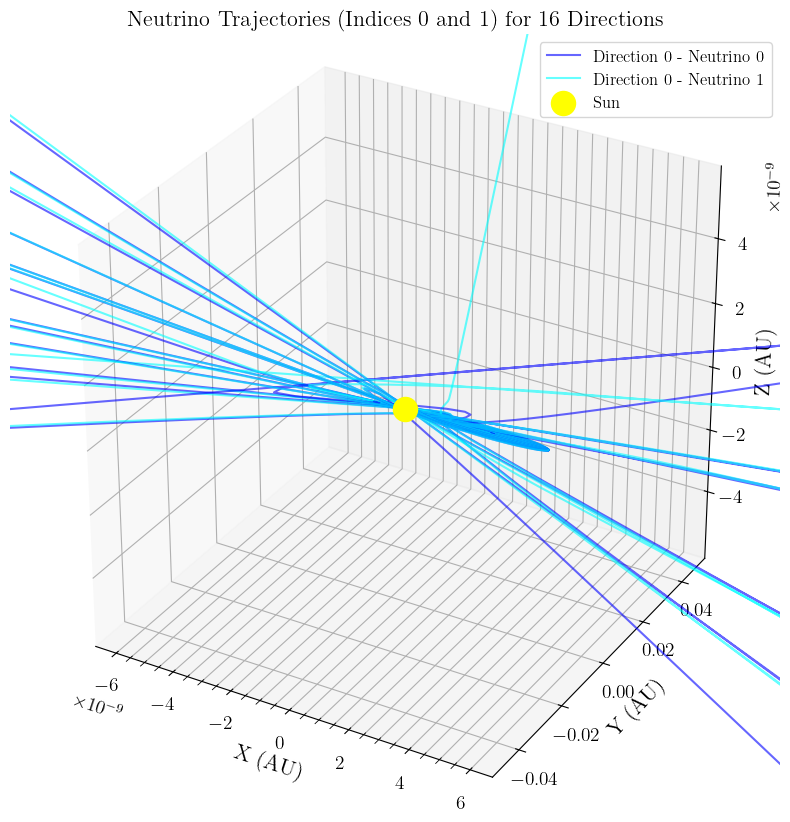

In [119]:
def plot_neutrino_trajectories(data, index1, index2):
    # Create a 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    max_extents = []
    Npix = data.shape[0]

    # Define colors for the two selected neutrinos
    color1 = (0, 0, 1, 0.6)  # Blue with alpha 0.6
    color2 = (0, 1, 1, 0.6)  # Cyan with alpha 0.6

    for direction in range(Npix):
        # Plot the two selected neutrinos for each direction
        for i, neutrino_index in enumerate([index1, index2]):
            # Extract the trajectory for the specified neutrino
            trajectory = data[direction, neutrino_index, :, :3]

            # Find the last non-nan point
            valid_mask = ~np.isnan(trajectory).any(axis=1)
            last_valid_index = np.where(valid_mask)[0][-1] if np.any(valid_mask) else -1
            
            if last_valid_index == -1:
                print(f"No valid data for direction {direction}, neutrino {neutrino_index}")
                continue

            valid_trajectory = trajectory[:last_valid_index + 1]

            # Calculate the maximum extent of the trajectory
            max_extent = np.max(np.abs(valid_trajectory), axis=0)
            max_extents.append(max_extent)

            # Plot the neutrino trajectory
            color = color1 if i == 0 else color2
            label = f'Direction {direction} - Neutrino {neutrino_index}'
            ax.plot(
                valid_trajectory[:, 0], valid_trajectory[:, 1], valid_trajectory[:, 2], 
                color=color, label=label if direction == 0 else "")

            # Plot the end point with a red cross
            end_point = valid_trajectory[-1]
            ax.scatter(
                end_point[0], end_point[1], end_point[2], 
                color='red', marker='x', s=50)

    # Plot the Sun
    ax.scatter(0, 0, 0, color='yellow', s=300, label='Sun')

    # Set labels and title
    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Y (AU)')
    ax.set_zlabel('Z (AU)')
    ax.set_title(f'Neutrino Trajectories (Indices {index1} and {index2}) for {Npix} Directions')

    # Set axis limits dynamically based on the maximum extent of all trajectories
    overall_max_extent = np.max(max_extents, axis=0)
    # ax.set_xlim(-overall_max_extent[0], overall_max_extent[0])
    # ax.set_ylim(-overall_max_extent[1], overall_max_extent[1])
    # ax.set_zlim(-overall_max_extent[2], overall_max_extent[2])

    overall_med_extent = np.min(max_extents, axis=0)
    ax.set_xlim(-overall_med_extent[0], overall_med_extent[0])
    ax.set_ylim(-overall_med_extent[1], overall_med_extent[1])
    ax.set_zlim(-overall_med_extent[2], overall_med_extent[2])

    # Add legend
    ax.legend()

    # Ensure equal aspect ratio
    ax.set_box_aspect((1, 1, 1))

    # Show the plot
    plt.show()


plot_neutrino_trajectories(nu_vectors_npix, 0, 1)

In [128]:
def check_nan_consistency(data):
    Npix, num_neutrinos, num_days, _ = data.shape
    
    # Initialize with -1 to indicate no NaNs found
    first_nan_day = -1
    consistent = True

    for direction in range(Npix):
        for neutrino in range(num_neutrinos):
            # Find the first day with NaN for this neutrino
            nan_mask = np.isnan(data[direction, neutrino, :, :]).any(axis=1)
            nan_days = np.where(nan_mask)[0]
            
            if len(nan_days) > 0:
                current_first_nan = nan_days[0]
                
                if first_nan_day == -1:
                    # This is the first NaN we've found, set it as the reference
                    first_nan_day = current_first_nan
                elif current_first_nan != first_nan_day:
                    # We found a NaN starting on a different day
                    consistent = False
                    print(f"Inconsistency found: Direction {direction}, Neutrino {neutrino} "
                          f"has first NaN on day {current_first_nan}")
                    return consistent, first_nan_day

    if first_nan_day == -1:
        print("No NaN values found in the dataset.")
    elif consistent:
        print(f"All NaN values consistently start on day {first_nan_day}")
    
    return consistent, first_nan_day


check_nan_consistency(nu_vectors_npix)

All NaN values consistently start on day 364


(True, 364)

In [116]:
s_int_steps.shape

(365,)

### Convert vectors to number densities

In [ ]:
# # Compute individual number densities for each healpixel
# nu_allsky_masses = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
# pix_dens = Physics.number_densities_all_sky(
#     v_arr=nu_vectors[..., 3:],
#     m_arr=nu_allsky_masses,
#     pix_sr=simdata.pix_sr,
#     args=Params())

# Plot outputs

In [ ]:
def modulation(nu_dens_days=None):
    
    # 1 to 365 for each day of the year
    days = jnp.arange(1, 366)
    
    # Placeholder, actual data after finishing project
    if nu_dens_days is None:
        nu_dens_days = jnp.ones_like(days)*56

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(days, nu_dens_days, label='FD_sim')

    # Customize x-axis to show ticks and labels only on specific dates
    tick_days = [305, 32, 122, 213]  # Corresponding to Nov 1, Feb 1, May 1, and Aug 1
    tick_labels = ['Nov 1', 'Feb 1', 'May 1', 'Aug 1']

    plt.xticks(tick_days, tick_labels)

    # Add labels and title
    plt.xlabel('Day of the Year')
    plt.ylabel('Number Density')
    plt.title('Number Densities Across the Year')
    plt.legend()

    # Show grid for better readability
    plt.grid(True, which="major", linestyle="dashed")

    # Display the plot
    plt.show()

modulation()